# RL market maker (single run)
Configure parameters below, optionally run a simulation (mm_compare with `--mm-type rl_baseline`), then plot key metrics for the RL agent and the market.

In [19]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

# ---- parameters ----
run_simulation = True  # set True to launch a run from the notebook
seed = 17365
ticker = 'AAPL'
historical_date = '20000101'
start_time = '09:30:00'
end_time = '11:30:00'
mm_type = 'rl_baseline'
log_name = f'rl_mm_seed_{seed}'
repo_root = Path('..')
log_dir = repo_root / 'log' / log_name
# --------------------

print('Log dir:', log_dir.resolve())

Log dir: /Users/salim/Desktop/Columbia/Assignments_Columbia/S3/Reinforcement Learning/Project/ABIDES/abides/log/rl_mm_seed_17365


## Run simulation (optional)
Requires mm_compare.py to be in repo root under `config/`.

In [20]:
if run_simulation:
    cmd = [
        'python', 'abides.py',
        '-c', 'mm_compare',
        '-t', ticker,
        '-d', historical_date,
        '--start-time', start_time,
        '--end-time', end_time,
        '--seed', str(seed),
        '--log_dir', log_name,
        '--mm-type', mm_type,
    ]
    print('Running:', ' '.join(cmd))
    result = subprocess.run(cmd, cwd=repo_root)
    print('Return code:', result.returncode)
else:
    print('Skipping simulation run; set run_simulation=True to execute.')

Running: python abides.py -c mm_compare -t AAPL -d 20000101 --start-time 09:30:00 --end-time 11:30:00 --seed 17365 --log_dir rl_mm_seed_17365 --mm-type rl_baseline
ABIDES: Agent-Based Interactive Discrete Event Simulation

Simulation Start Time: 2025-12-01 11:38:28.328238
Configuration seed: 17365


--- Simulation time: 2000-01-01 00:00:00, messages processed: 0, wallclock elapsed: 0 days 00:00:00.000008 ---

Final holdings for NoiseAgent 1: { CASH: 10000000 }.  Marked to market: 10000000
Final relative surplus NoiseAgent 1 0.0
Final holdings for Value Agent 2: { AAPL: 151, CASH: -5420908 }.  Marked to market: 9717446
Final holdings for Value Agent 3: { AAPL: -379, CASH: 48823079 }.  Marked to market: 10826813
Final holdings for Value Agent 4: { AAPL: 31, CASH: 6423061 }.  Marked to market: 9530935
Final holdings for Value Agent 5: { AAPL: 171, CASH: -7230153 }.  Marked to market: 9913281
Final holdings for Value Agent 6: { AAPL: 41, CASH: 5895400 }.  Marked to market: 10005814
Final h

Processing orderbook log: 100%|██████████| 3480/3480 [00:00<00:00, 34620.67it/s]


Order book logging complete!
Time taken to log the order book: 0:00:00.239770
Order book archival complete.
Event Queue elapsed: 0 days 00:00:01.076671, messages: 27987, messages per second: 25994.0
Mean ending value by agent type:
NoiseAgent: 0
ValueAgent: -1142
RLMarketMakerAgent: 5711
Simulation ending!
Simulation End Time: 2025-12-01 11:38:29.824572
Time taken to run simulation: 0:00:01.496334
Return code: 0


## Load logs

In [21]:
summary_path = log_dir / 'summary_log.bz2'
orderbook_file = next(log_dir.glob('ORDERBOOK_*_FULL.bz2'), None)
if not summary_path.exists():
    raise FileNotFoundError(summary_path)

summary = pd.read_pickle(summary_path)
summary.head()

,AgentID,AgentStrategy,EventType,Event
0,1,NoiseAgent,STARTING_CASH,10000000.0
1,2,ValueAgent,STARTING_CASH,10000000.0
2,3,ValueAgent,STARTING_CASH,10000000.0
3,4,ValueAgent,STARTING_CASH,10000000.0
4,5,ValueAgent,STARTING_CASH,10000000.0


### Summary PnL by strategy

In [22]:
wide = summary.pivot_table(index=['AgentID', 'AgentStrategy'], columns='EventType', values='Event', aggfunc='first')
wide['PNL'] = wide['ENDING_CASH'] - wide['STARTING_CASH']
wide.reset_index().sort_values('PNL', ascending=False).head(10)

EventType,AgentID,AgentStrategy,ENDING_CASH,FINAL_CASH_POSITION,FINAL_VALUATION,STARTING_CASH,PNL
2,3,ValueAgent,10826813.0,48823079.0,3.842212,10000000.0,826813.0
5,6,ValueAgent,10005814.0,5895400.0,-0.410460,10000000.0,5814.0
6,7,RLMarketMakerAgent,10005711.0,11509521.0,NaN,10000000.0,5711.0
0,1,NoiseAgent,10000000.0,10000000.0,0.000000,10000000.0,0.0
4,5,ValueAgent,9913281.0,-7230153.0,-1.702967,10000000.0,-86719.0
1,2,ValueAgent,9717446.0,-5420908.0,-1.522043,10000000.0,-282554.0
3,4,ValueAgent,9530935.0,6423061.0,-0.357694,10000000.0,-469065.0


## RL agent log

In [23]:
rl_files = list(log_dir.glob('RL_MARKET_MAKER_AGENT_*.bz2'))
if not rl_files:
    raise FileNotFoundError('No RL_MARKET_MAKER_AGENT logs found')
rl_log = pd.read_pickle(rl_files[0])
print('RL log columns:', list(rl_log.columns))
rl_log.head()

RL log columns: ['EventType', 'Event']


,EventType,Event
EventTime,,
NaT,AGENT_TYPE,RLMarketMakerAgent
NaT,STARTING_CASH,10000000
2000-01-01 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2000-01-01 09:30:10.007342208,BID_DEPTH,"[(99875, 43)]"
2000-01-01 09:30:10.007342208,ASK_DEPTH,"[(99933, 27)]"


### Inventory, cash, mark-to-market

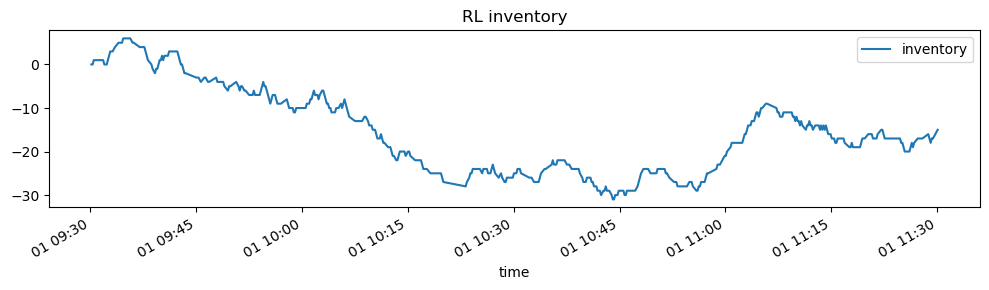

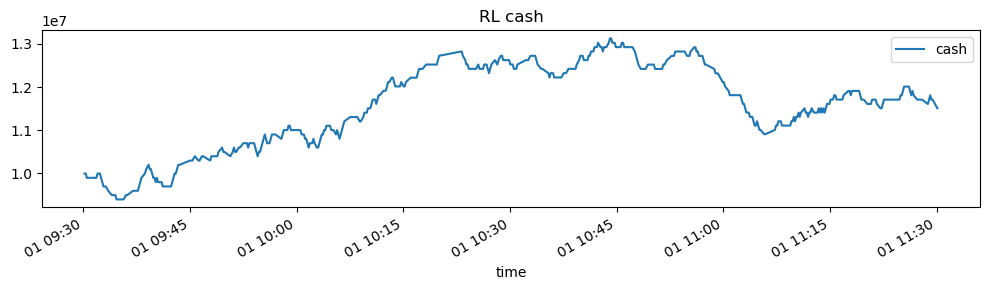

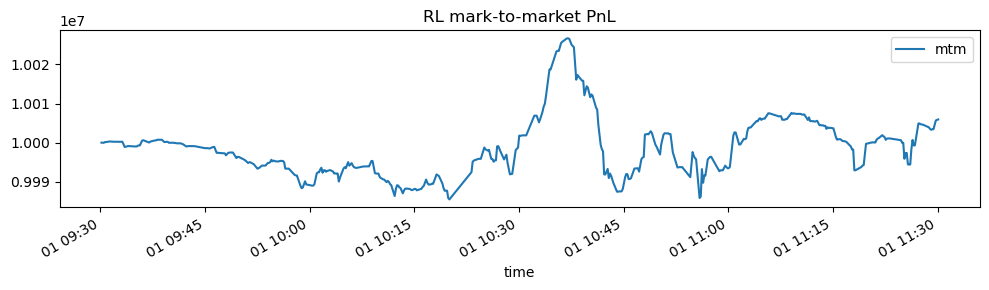

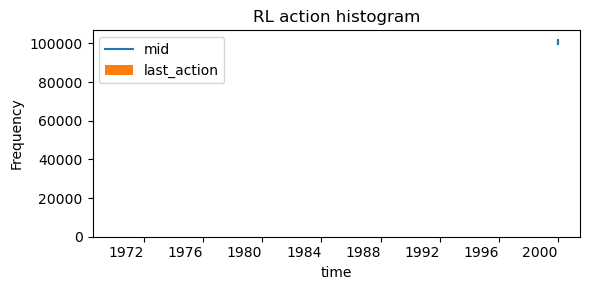

In [24]:
# STATE events contain time, mid, inventory, cash, mtm, last_action
state_rows = rl_log[rl_log['EventType'] == 'STATE']
if not state_rows.empty:
    state_df = pd.DataFrame(list(state_rows['Event']))
    state_df = state_df.set_index('time')
    ax = state_df[['inventory']].plot(figsize=(10,3), title='RL inventory', legend=True)
    ax.legend(['inventory'])
    plt.tight_layout()
    ax = state_df[['cash']].plot(figsize=(10,3), title='RL cash', legend=True)
    ax.legend(['cash'])
    plt.tight_layout()
    ax = state_df[['mtm']].plot(figsize=(10,3), title='RL mark-to-market PnL', legend=True)
    ax.legend(['mtm'])
    plt.tight_layout()
    ax = state_df[['mid']].plot(figsize=(10,3), title='Mid price observed by RL', legend=True)
    ax.legend(['mid'])
    plt.tight_layout()
    state_df['last_action'].plot(kind='hist', bins=10, figsize=(6,3), title='RL action histogram', label='last_action')
    plt.legend()
    plt.tight_layout()
else:
    print('No STATE events found in RL log')


## Order book and fundamental

Orderbook columns: [99612, 99651, 99656, 99726, 99738, 99742, 99750, 99758, 99775, 99780, 99789, 99798, 99805, 99812, 99820, 99821, 99825, 99826, 99829, 99830, 99837, 99841, 99842, 99843, 99844, 99845, 99847, 99848, 99849, 99850, 99851, 99852, 99853, 99854, 99855, 99856, 99858, 99859, 99861, 99862, 99864, 99867, 99868, 99869, 99871, 99872, 99873, 99874, 99875, 99876, 99877, 99878, 99880, 99881, 99883, 99888, 99889, 99890, 99891, 99892, 99895, 99897, 99898, 99900, 99901, 99902, 99903, 99904, 99905, 99909, 99912, 99914, 99916, 99918, 99919, 99921, 99922, 99923, 99933, 99937, 99940, 99946, 99947, 99950, 99952, 99953, 99961, 99963, 99964, 99972, 99974, 99975, 99976, 99979, 99983, 99984, 99986, 99988, 99989, 99990, 99991, 99992, 99996, 99998, 100000, 100004, 100005, 100006, 100007, 100012, 100013, 100014, 100022, 100026, 100028, 100029, 100030, 100031, 100032, 100036, 100041, 100043, 100044, 100045, 100047, 100049, 100051, 100055, 100058, 100060, 100063, 100064, 100065, 100067, 100070, 1000

,99612,99651,99656,99726,99738,99742,99750,99758,99775,99780,...,101662,101664,101665,101668,101683,101684,101693,101695,101716,101732
QuoteTime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 09:30:00.000360785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-01 09:30:00.004269265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-01 09:30:00.007569920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-01 09:30:00.013522061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-01 09:30:00.014304245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


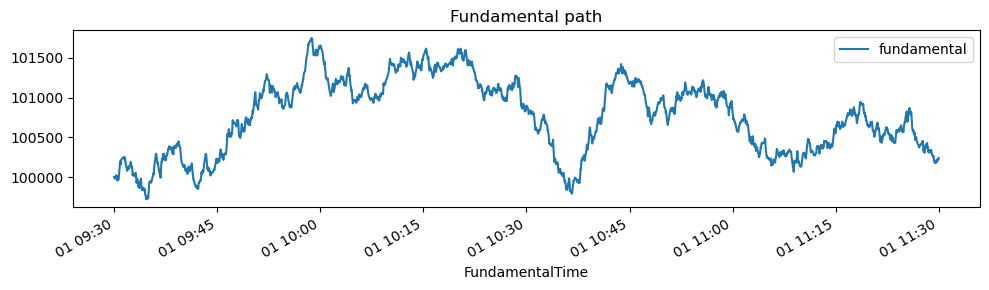

In [25]:
if orderbook_file:
    orderbook = pd.read_pickle(orderbook_file)
    print('Orderbook columns:', list(orderbook.columns))
    # try to find top-of-book prices
    def find_col(columns, substrings):
        for col in columns:
            name = ' '.join(col) if isinstance(col, tuple) else str(col)
            lname = name.lower()
            if all(sub in lname for sub in substrings):
                return col
        return None
    bid_price_col = find_col(orderbook.columns, ['best', 'bid']) or find_col(orderbook.columns, ['bid', 'price'])
    ask_price_col = find_col(orderbook.columns, ['best', 'ask']) or find_col(orderbook.columns, ['ask', 'price'])
    if bid_price_col and ask_price_col:
        top = orderbook[[bid_price_col, ask_price_col]].copy()
        top.columns = ['best_bid_price', 'best_ask_price']
        top['mid'] = (top['best_bid_price'] + top['best_ask_price']) / 2
        top['spread'] = top['best_ask_price'] - top['best_bid_price']
        ax = top[['mid']].plot(figsize=(10,3), title='Mid price', legend=True)
        ax.legend(['mid'])
        plt.tight_layout()
        ax = top[['spread']].plot(figsize=(10,3), title='Quoted spread', legend=True)
        ax.legend(['spread'])
        plt.tight_layout()
    else:
        display(orderbook.head())
else:
    print('Orderbook file not found')

fund_file = next(log_dir.glob('fundamental_*.bz2'), None)
if fund_file:
    fundamental = pd.read_pickle(fund_file).reset_index()
    fundamental.plot(x='FundamentalTime', y='FundamentalValue', legend=True, figsize=(10,3), title='Fundamental path', label='fundamental')
    plt.tight_layout()
else:
    print('Fundamental file not found')


### Rewards and actions over time

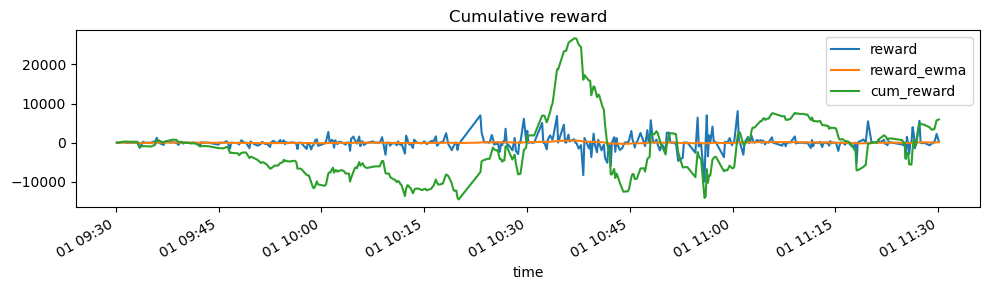

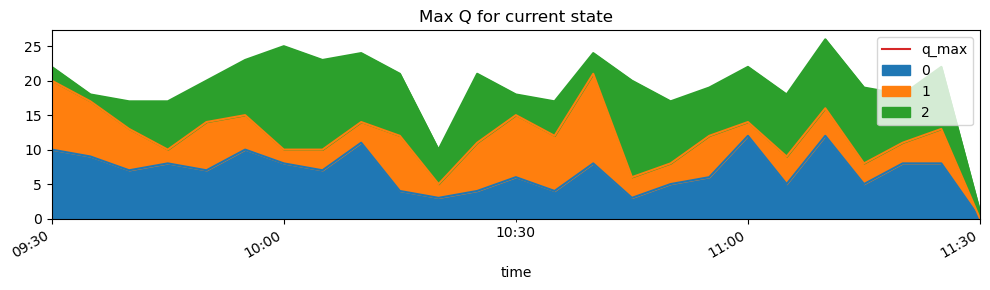

In [26]:
if not state_rows.empty:
    # ensure time index is datetime
    state_df = state_df.copy()
    state_df.index = pd.to_datetime(state_df.index)
    state_df['reward'].plot(figsize=(10,3), title='Step reward', label='reward')
    plt.legend()
    plt.tight_layout()
    state_df['reward'].ewm(span=100).mean().plot(figsize=(10,3), title='Reward EWMA (span=100)', label='reward_ewma')
    plt.legend()
    plt.tight_layout()
    state_df['cum_reward'].plot(figsize=(10,3), title='Cumulative reward', label='cum_reward')
    plt.legend()
    plt.tight_layout()
    # action share over time (5-minute buckets)
    action_share = state_df['last_action'].resample('5T').apply(lambda s: s.value_counts()).unstack(fill_value=0)
    action_share.plot.area(figsize=(10,3), title='Action counts per 5 min')
    plt.legend(title='action')
    plt.tight_layout()
    state_df['q_max'].plot(figsize=(10,3), title='Max Q for current state', label='q_max')
    plt.legend()
    plt.tight_layout()
else:
    print('No STATE events found in RL log')


### State visitation and greedy policy heatmaps

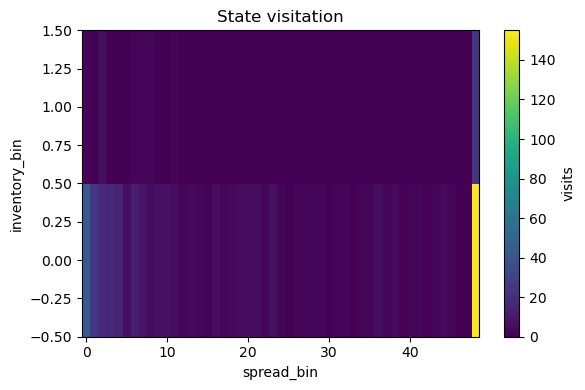

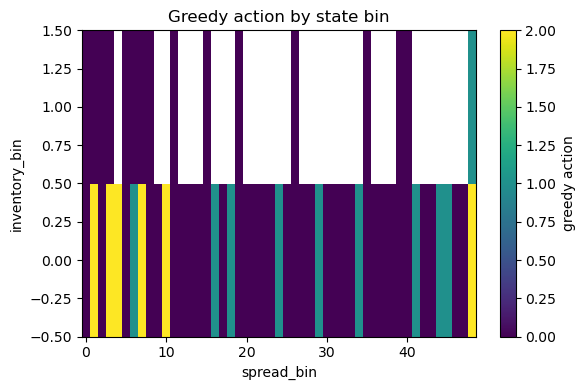

In [27]:
if not state_rows.empty:
    visit = state_df.groupby(['inventory_bin', 'spread_bin']).size().unstack(fill_value=0)
    plt.figure(figsize=(6,4))
    plt.imshow(visit, origin='lower', aspect='auto')
    plt.colorbar(label='visits')
    plt.xlabel('spread_bin')
    plt.ylabel('inventory_bin')
    plt.title('State visitation')
    plt.tight_layout()
    greedy = state_df.groupby(['inventory_bin', 'spread_bin'])['greedy_action'].agg(lambda x: x.value_counts().index[0])
    greedy = greedy.unstack()
    plt.figure(figsize=(6,4))
    plt.imshow(greedy, origin='lower', aspect='auto')
    plt.colorbar(label='greedy action')
    plt.xlabel('spread_bin')
    plt.ylabel('inventory_bin')
    plt.title('Greedy action by state bin')
    plt.tight_layout()
else:
    print('No STATE events found in RL log')
